## Compare Regression with CART Predictor: BlueBike Rentals Case

#### Introduction: Packages and Data

In [34]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor, plot_tree


In [35]:
#import data
df = pd.read_csv("rentals_weather.csv")

In [36]:
#inspect data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rentals        8603 non-null   int64  
 1   month          8603 non-null   int64  
 2   day            8603 non-null   int64  
 3   hour           8603 non-null   int64  
 4   day_of_week    8603 non-null   object 
 5   weekend        8603 non-null   int64  
 6   temp           8603 non-null   int64  
 7   temp_wb        8603 non-null   int64  
 8   rel_humidity   8603 non-null   int64  
 9   windspeed      8603 non-null   int64  
 10  precipitation  8603 non-null   float64
dtypes: float64(1), int64(9), object(1)
memory usage: 739.4+ KB


In [37]:
df.head()

,rentals,month,day,hour,day_of_week,weekend,temp,temp_wb,rel_humidity,windspeed,precipitation
0,4,1,1,0,Mon,0,2,0,59,16,0.0
1,6,1,1,1,Mon,0,1,0,59,11,0.0
2,6,1,1,2,Mon,0,1,-1,54,21,0.0
3,1,1,1,5,Mon,0,0,-2,54,18,0.0
4,3,1,1,6,Mon,0,0,-2,54,15,0.0


In [38]:
#deal with cotegorical variables
categoricals = ["month", "day", "hour", "day_of_week", "weekend"]
df[categoricals] = df[categoricals].astype("category")

In [8]:
df.rentals.describe()

count    8603.000000
mean      205.085784
std       227.052462
min         1.000000
25%        32.000000
50%       120.000000
75%       306.000000
max      1299.000000
Name: rentals, dtype: float64

#### Split the Data: Train & Test

In [39]:
#import module and split the data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.3, shuffle = True, random_state = 42)

In [40]:
#create independent variables as series as dataframes with dependent variables
x = df_train.copy()
y = x.pop("rentals")
x_test = df_test.copy()
y_test = x_test.pop("rentals")

#### Build OLS Regression Model

In [41]:
#build empty model
formula = 'rentals ~ ' + '+'.join(df.columns[1:])
est = ols(formula = formula, data = df_train).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     177.1
Date:                Thu, 27 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:56:07   Log-Likelihood:                -37739.
No. Observations:                6022   AIC:                         7.563e+04
Df Residuals:                    5946   BIC:                         7.614e+04
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -163.4356     23

Now let's calculate the out of sample R2 with the help of a helper function

In [42]:
#Helper function
def OSR2(y_pred, y_true, training_mean):
    baseline_error = np.sum(np.square((training_mean- y_true)))
    model_error = np.sum(np.square((y_pred - y_true)))
    return 1.0- model_error/baseline_error

In [43]:
#use the function to calculate OSR2
OSR2(est.predict(x_test), y_test, y.mean())

np.float64(0.6832349952617289)

OSR2 of the OLS Regression Model is 0.68. Let's see if we can do better with a CART Regression Model

#### Regression Trees

In [44]:
tree = DecisionTreeRegressor(random_state = 42)

In [45]:
# we need to get dummies for the categorical variables
x = pd.get_dummies(x, columns = categoricals)
x_test = pd.get_dummies(x_test, columns = categoricals)

In [46]:
#CART tree with default settings
tree.fit(x,y)

DecisionTreeRegressor(random_state=42)

In [47]:
#lets use the manual function defined above to find the Out of Sample R2. 
OSR2(tree.predict(x), y, y.mean())

np.float64(1.0)

In [48]:
#check out the tree size and shape
tree.tree_.node_count, tree.tree_.max_depth

(11301, 47)

This tree is too big and complex and it is overfitting. The OSR2 of 1.0 is a sign of this. Let's try to avoid overfitting by using predetrmined hyperparamenters. 

In [49]:
#before we do that, let's see how the default model above does on the test data
OSR2(tree.predict(x_test), y_test, y.mean())

np.float64(0.7824430330733544)

#### Cost Complexity Pruning: CCP

In [51]:

tree = DecisionTreeRegressor(random_state = 42)

In [53]:
#set a path to include the ccp alphas to use in the process of determining the best tree
path = tree.cost_complexity_pruning_path(x,y)
alphas = path.ccp_alphas
len(alphas)

5186

In [54]:
# let's generate a random list of about 50 trees from the large number of trees above. we revers the alphas, to prune the more complex trees first.
alphas_small = alphas[::100]
alphas_small = alphas_small[::-1]

In [56]:
# use a loop to create trees for all the alphas above, and save their r2 and osr2 perfromance to a list
r2_all = []
osr2_all = []
node_counts = []

for alpha in alphas_small:
    tree = DecisionTreeRegressor(random_state = 42, ccp_alpha = alpha)
    tree.fit(x,y)
    y_pred = tree.predict(x)
    r2_all.append(OSR2(y_pred, y, y.mean()))
    y_pred = tree.predict(x_test)
    osr2_all.append(OSR2(y_pred, y_test, y.mean()))
    node_counts.append(tree.tree_.node_count)

Text(0.5, 1.0, 'Prediction Quality vs. Tree Size')

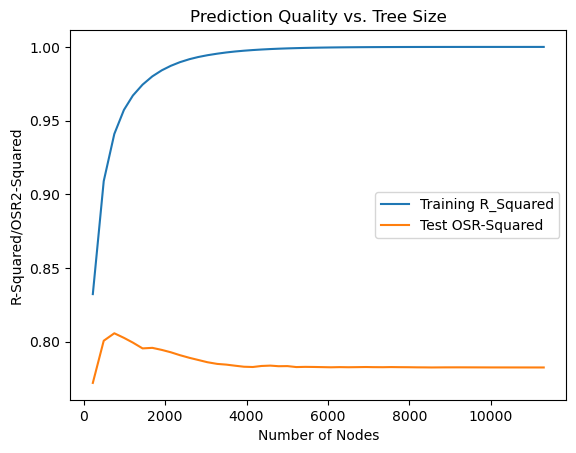

In [57]:
#lets plot the trees and the performance for both train and test data
plt.plot(node_counts, r2_all, label = "Training R_Squared")
plt.plot(node_counts, osr2_all, label = "Test OSR-Squared")
plt.legend()
plt.xlabel("Number of Nodes")
plt.ylabel("R-Squared/OSR2-Squared")
plt.title("Prediction Quality vs. Tree Size")

In [59]:
# let's find the best tree, i.e. the one with the highest OSR2.
opt_idx = np.argmax(osr2_all)


In [60]:
#lets fit it to the model
tree = DecisionTreeRegressor (random_state = 42, ccp_alpha = alphas_small[opt_idx])
tree.fit(x,y)

DecisionTreeRegressor(ccp_alpha=np.float64(9.300806457131927), random_state=42)

In [61]:
#lets find out the shape of this tree
tree.tree_.node_count, tree.tree_.max_depth

(753, 30)

In [65]:
#lets visualize it
def viz_tree(tree, font=12, figsize=(16,10)):
  '''
  draws a classification tree
  '''
  plt.figure(figsize=figsize)  # set plot size (denoted in inches)
  _ = plot_tree(tree,
                feature_names=x.columns,
                filled=True,
                fontsize=font)


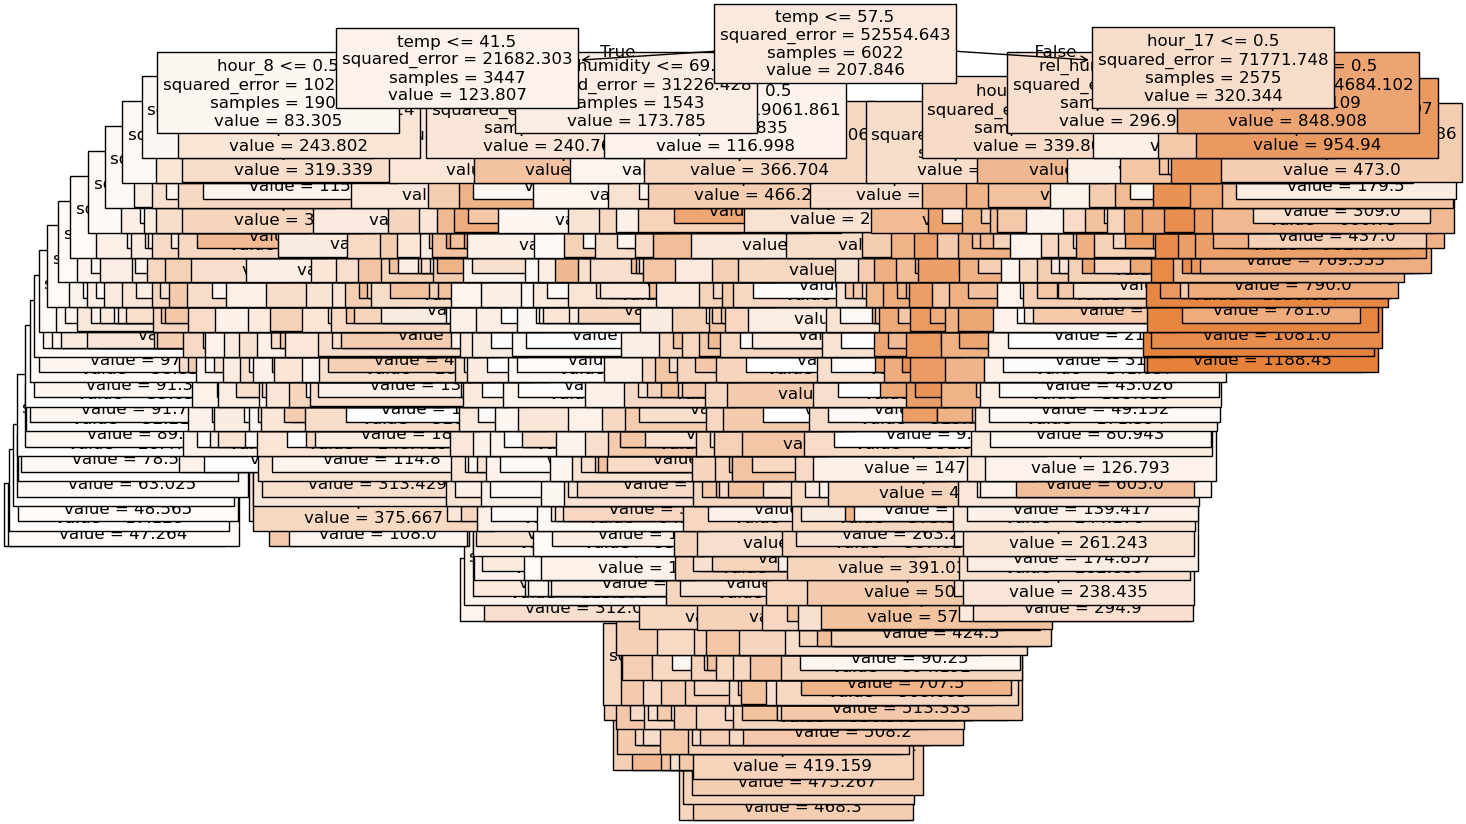

In [66]:
viz_tree(tree)

In [67]:
#lets find the OSR2 for this tree
OSR2(tree.predict(x_test), y_test, y.mean())

np.float64(0.8056467590667243)

## The End!